<a href="https://colab.research.google.com/github/JairAlbertoHuertaDiaz45/Simulaci-n-II/blob/main/Ejercicio_4_A_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
from scipy.stats import norm
# Función Black–Scholes Call ajustado por dividendos
def black_scholes_call_div(S0, K, r, sigma, T, dividends):
    """
    Valúa una opción Call europea con dividendos discretos
    """
    PV_div = sum(d * np.exp(-r * t) for d, t in dividends)
    S_adj = S0 - PV_div

    d1 = (np.log(S_adj / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S_adj * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Entrada de datos por el usuario

print("VALUACIÓN DE OPCIÓN CALL CON DIVIDENDOS\n")

S0 = float(input("Precio actual del activo S0: "))
K = float(input("Precio de ejercicio K: "))
r = float(input("Tasa libre de riesgo anual (ej. 0.08): "))
sigma = float(input("Volatilidad anual (ej. 0.30): "))
T = float(input("Tiempo al vencimiento (en años): "))

n_div = int(input("Número de dividendos: "))

dividends = []
for i in range(n_div):
    d = float(input(f"Dividendo {i+1} (monto): "))
    t = float(input(f"Tiempo del dividendo {i+1} (en años): "))
    dividends.append((d, t))

# Precio de la opción Call europea

call_price = black_scholes_call_div(S0, K, r, sigma, T, dividends)

print("\nRESULTADOS GENERALES")
print(f"Precio de la opción Call europea: {call_price:.4f}")

# Evaluación de ejercicio anticipado por dividendo

print("\nANÁLISIS DE EJERCICIO ANTICIPADO")

for i, (d, t_d) in enumerate(dividends, start=1):

    S_td = S0 * np.exp(r * t_d) - d
    valor_ejercer = max(S_td - K, 0)

    # Precio de la opción justo después del dividendo
    div_restantes = [(dj, tj - t_d) for dj, tj in dividends if tj > t_d]
    T_restante = T - t_d

    if T_restante > 0:
        call_continuar = black_scholes_call_div(
            S_td, K, r, sigma, T_restante, div_restantes
        )
    else:
        call_continuar = 0

    print(f"\nDividendo {i}:")
    print(f"Valor por ejercer anticipadamente: {valor_ejercer:.4f}")
    print(f"Valor por continuar: {call_continuar:.4f}")

    if valor_ejercer > call_continuar:
        print("→ Conviene ejercer anticipadamente antes del dividendo.")
    else:
        print("→ NO conviene ejercer anticipadamente antes del dividendo.")

# Conclusión final

print("\nCONCLUSIÓN FINAL")
print("El precio óptimo de la opción se determina comparando")
print("el valor por ejercicio anticipado contra el valor de continuar.")
print("La decisión óptima es la que maximiza el valor económico.")


VALUACIÓN DE OPCIÓN CALL CON DIVIDENDOS

Precio actual del activo S0: 106
Precio de ejercicio K: 105
Tasa libre de riesgo anual (ej. 0.08): 0.08
Volatilidad anual (ej. 0.30): 0.3
Tiempo al vencimiento (en años): 0.333
Número de dividendos: 1
Dividendo 1 (monto): 2
Tiempo del dividendo 1 (en años): 0.083

RESULTADOS GENERALES
Precio de la opción Call europea: 8.0352

ANÁLISIS DE EJERCICIO ANTICIPADO

Dividendo 1:
Valor por ejercer anticipadamente: 0.0000
Valor por continuar: 7.1399
→ NO conviene ejercer anticipadamente antes del dividendo.

CONCLUSIÓN FINAL
El precio óptimo de la opción se determina comparando
el valor por ejercicio anticipado contra el valor de continuar.
La decisión óptima es la que maximiza el valor económico.


**Ejercicio 4b.**

EJERCICIO 4 – INCISO B

Precio Call Europea (Black–Scholes): 11.6360
Precio Call Americana (Binomial): 15.2722

No conviene ejercer anticipadamente antes de ningún dividendo.


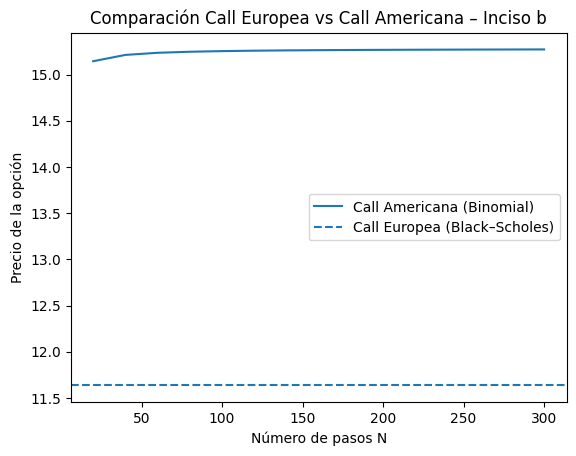

In [5]:
# ============================================================
# EJERCICIO 4 – INCISO B
# Call Europea vs Call Americana
# Identificación del dividendo óptimo para ejercer
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# ------------------------------------------------------------
# 1. Datos del problema
# ------------------------------------------------------------
S0 = 110
K = 110
T = 1.0
r = 0.08
sigma = 0.25

# Dividendos: (monto, tiempo en años)
dividends = [
    (1.50, 1/12),
    (1.50, 4/12),
    (1.50, 9/12),
    (1.50, 10/12)
]


# ------------------------------------------------------------
# 2. Black–Scholes Call Europea con dividendos
# ------------------------------------------------------------
def black_scholes_call_div(S0, K, r, sigma, T, dividends):

    PV_div = sum(d * np.exp(-r * t) for d, t in dividends)
    S_adj = S0 - PV_div

    d1 = (np.log(S_adj / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return S_adj * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


# ------------------------------------------------------------
# 3. Binomial CRR – Call Americana
#    Detección de ejercicio anticipado por dividendo
# ------------------------------------------------------------
def binomial_call_american_dividend_analysis(
    S0, K, r, sigma, T, N, dividends
):

    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Mapeo de dividendos a pasos del árbol
    dividend_steps = {
        int(t / dt): (amount, t)
        for amount, t in dividends
    }

    exercise_dividends = set()

    ST = np.array([S0 * (u**j) * (d**(N - j)) for j in range(N + 1)])
    payoff = np.maximum(ST - K, 0)

    for i in range(N - 1, -1, -1):

        ST = np.array([S0 * (u**j) * (d**(i - j)) for j in range(i + 1)])

        # Ajuste por dividendo
        if i in dividend_steps:
            ST -= dividend_steps[i][0]

        continuation = np.exp(-r * dt) * (p * payoff[1:] + (1 - p) * payoff[:-1])
        intrinsic = np.maximum(ST - K, 0)

        # Verificar si conviene ejercer antes del dividendo
        if i in dividend_steps and np.any(intrinsic > continuation):
            exercise_dividends.add(dividend_steps[i][1])

        payoff = np.maximum(continuation, intrinsic)

    return payoff[0], sorted(exercise_dividends)


# ------------------------------------------------------------
# 4. Cálculo de precios
# ------------------------------------------------------------
call_europea = black_scholes_call_div(S0, K, r, sigma, T, dividends)

N = 300
call_americana, exercise_div_times = binomial_call_american_dividend_analysis(
    S0, K, r, sigma, T, N, dividends
)


# ------------------------------------------------------------
# 5. Resultados
# ------------------------------------------------------------
print("EJERCICIO 4 – INCISO B\n")

print(f"Precio Call Europea (Black–Scholes): {call_europea:.4f}")
print(f"Precio Call Americana (Binomial): {call_americana:.4f}\n")

if exercise_div_times:
    print("Conviene ejercer anticipadamente justo ANTES de los siguientes dividendos:")
    for t in exercise_div_times:
        print(f"- Dividendo pagado en t = {t:.2f} años")
else:
    print("No conviene ejercer anticipadamente antes de ningún dividendo.")


# ------------------------------------------------------------
# 6. Gráfica de comparación
# ------------------------------------------------------------
N_values = range(20, 301, 20)
call_amer_vals = []

for n in N_values:
    price, _ = binomial_call_american_dividend_analysis(
        S0, K, r, sigma, T, n, dividends
    )
    call_amer_vals.append(price)

plt.figure()
plt.plot(N_values, call_amer_vals, label="Call Americana (Binomial)")
plt.axhline(call_europea, linestyle="--", label="Call Europea (Black–Scholes)")
plt.xlabel("Número de pasos N")
plt.ylabel("Precio de la opción")
plt.title("Comparación Call Europea vs Call Americana – Inciso b")
plt.legend()
plt.show()

**Ejercicio 5**

\section*{Ejercicio 5: Demostración de la paridad Put--Call en el modelo de Black--Scholes}

\subsection*{Enunciado} Demuestre que el modelo de Black--Scholes satisface la ecuación de paridad Put--Call.

\subsection*{Planteamiento} Sea un activo subyacente sin pagos intermedios (sin dividendos), cuyo precio actual es $S_0$. Considérese una opción \textit{Call} europea y una opción \textit{Put} europea, ambas con: \begin{itemize} \item Precio de ejercicio $K$ \item Tiempo al vencimiento $T$ \item Tasa libre de riesgo constante $r$ \end{itemize}

La \textbf{paridad Put--Call} establece que: \begin{equation} C - P = S_0 - K e^{-rT} \end{equation}

donde $C$ es el precio de la opción Call europea y $P$ el precio de la opción Put europea.

\subsection*{Precios en el modelo de Black--Scholes} De acuerdo con el modelo de Black--Scholes, los precios de las opciones europeas están dados por:

\begin{equation} C = S_0 N(d_1) - K e^{-rT} N(d_2) \end{equation}

\begin{equation} P = K e^{-rT} N(-d_2) - S_0 N(-d_1) \end{equation}

donde: \begin{equation} d_1 = \frac{\ln(S_0/K) + (r + \tfrac{1}{2}\sigma^2)T}{\sigma \sqrt{T}}, \quad d_2 = d_1 - \sigma \sqrt{T} \end{equation}

y $N(\cdot)$ denota la función de distribución acumulada de una normal estándar.

\subsection*{Demostración algebraica} Restando el precio del Put al precio del Call se obtiene:

\begin{align} C - P &= \left[S_0 N(d_1) - K e^{-rT} N(d_2)\right] \ &\quad - \left[K e^{-rT} N(-d_2) - S_0 N(-d_1)\right] \end{align}

Reordenando términos:

\begin{equation} C - P = S_0 \left[N(d_1) + N(-d_1)\right] - K e^{-rT} \left[N(d_2) + N(-d_2)\right] \end{equation}

Utilizando la propiedad de la distribución normal estándar: \begin{equation} N(x) + N(-x) = 1 \end{equation}

se obtiene:

\begin{equation} C - P = S_0 - K e^{-rT} \end{equation}

\subsection*{Conclusión} Se ha demostrado que los precios de las opciones Call y Put europeas obtenidos mediante el modelo de Black--Scholes satisfacen la relación de paridad Put--Call. Esta relación refleja un principio fundamental de no arbitraje en los mercados financieros, ya que cualquier violación de dicha igualdad permitiría construir estrategias de arbitraje sin riesgo.

\subsection*{Observación} La demostración es válida bajo los supuestos del modelo de Black--Scholes: ausencia de dividendos, mercados completos, posibilidad de operar continuamente y tasa libre de riesgo constante. En presencia de dividendos, la ecuación de paridad debe ajustarse incorporando el valor presente de los mismos.